# Aufgabe 1 (5P)

## a)
Nutzen Sie vom Datensatz „pvtest.csv“ die Werte 'Edaily','Dci','Dcp','Dcu','Temp1','hour‘ und erstellen Sie einen DataFrame
als Zeitreihe, ähnlich wie unten abgebildet. Auf Grundlage dieser Daten soll der Energieertrag Dcp immer in 5 Minuten in
der Zukunft prognostiziert werden. (0.5P)

<img src='images/1a.png' width=400>

In [96]:
import matplotlib.pyplot as plt
import pandas as pd

df_1 = pd.read_csv('pvtest.csv')
df_1['Time'] = pd.to_datetime(df_1['Time'], format='%d.%m.%y %H:%M')
df_1['hour'] = df_1['Time'].dt.hour
df_1 = df_1.set_index('Time')

columns = ['Edaily','Dci','Dcp','Dcu','Temp1','hour']
df_1 = df_1[columns].copy()
df_1.sort_values(by="Time", inplace=True)

print(df_1.loc['2021-01-26 16:25:00':'2021-01-26 17:40:00'])
df_1.shape

                     Edaily       Dci  Dcp  Dcu  Temp1  hour
Time                                                        
2021-01-26 16:25:00   3.108  0.192504  113  587   14.0    16
2021-01-26 16:30:00   3.122  0.111913   62  554   14.0    16
2021-01-26 16:35:00   3.130  0.053846   28  520   14.0    16
2021-01-26 16:40:00   3.137  0.041176   21  510   14.0    16
2021-01-26 16:45:00   3.141  0.024283   11  453   14.0    16
2021-01-26 16:50:00   3.144  0.000000    0  271   14.0    16
2021-01-26 16:55:00   3.145  0.000000    0  257   13.0    16
2021-01-26 17:00:00   3.145  0.000000    0  251   12.0    17
2021-01-26 17:05:00   3.145  0.000000    0  250   12.0    17
2021-01-26 17:10:00   3.145  0.000000    0   37    1.0    17
2021-01-26 17:15:00   3.145  0.000000    0    0    0.0    17
2021-01-26 17:20:00   3.145  0.000000    0    0    0.0    17
2021-01-26 17:25:00   3.145  0.000000    0    0    0.0    17
2021-01-26 17:35:00   3.145  0.000000    0    0    0.0    17
2021-01-26 17:40:00   3.

(3545, 6)

## b)
Teilen Sie die Daten sinnvoll in Lern-und Testdatensatz auf, so dass die zeitlichen Reihenfolgen bestehen bleiben ! (0.5P)

In [97]:
from sklearn.model_selection import train_test_split

x = df_1
y = df_1[['Dcp']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

## c)
Standardisieren Sie die Daten mit dem Standardscaler und restrukturieren Sie die Zeitreihe in einzelne Datenfenster, so dass
Sie aus allen vorhandenen 6 Features aus den letzten drei Stunden immer jeweils den Energieertrag für die nächsten 5
Minuten vorhersagen können. (1,5P)

In [98]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# standardize training data
scaler_x = StandardScaler()

# teaching (anlernen) and training
x_train_std = scaler_x.fit_transform(x_train)
x_test_std = scaler_x.transform(x_test)

scaler_y = StandardScaler()
y_train_std = scaler_y.fit_transform(y_train)
y_test_std = scaler_y.transform(y_test)

print(x_train_std.shape, y_train_std.shape)

# Needs to be changed
window = 12 * 3

horizon = 1

# 6 Features
indicators = 6

def restructure_data(X, y, window, horizon):
    # lists in order to define the timestamps and related target variables
    X_, y_ = [], []
    # new range of the index for new matrices
    idx_range = range(len(X) - (window + horizon))
    for idx in idx_range:
        # cutting out matrices
        X_.append(X[idx:idx+window])
        # slice [idx: idx+window] (search y-value)
        y_.append(y[idx+window+horizon])
    # parsing values to numpy arrays
    X_ = np.array(X_)
    y_ = np.array(y_)
    return X_, y_

# matrix (m,n) m rows and n columns
x_train, y_train = restructure_data(x_train_std,y_train_std,window,horizon)
x_test, y_test = restructure_data(x_test_std,y_test_std,window,horizon)

(2836, 6) (2836, 1)


# d)
Definieren und kompilieren Sie jetzt ein passendes Modell in Keras, welches mind. eine LSTM-Layer nutzt und DropoutLayer einfügt, um „Überanpassung“ zu verhindern. (1P)

In [99]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Dense, Bidirectional, Dropout)

model = Sequential()
model.add(Bidirectional(LSTM(units=16, return_sequences=True, dropout=0.2),
input_shape=(window, indicators)))
model.add(LSTM(units=32, dropout=0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
model.summary()

C:\Users\Muhammed Korkmaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_7 (Bidirectional) │ (None, 36, 32)         │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,353 (48.25 KB)

 Trainable params: 12,353 (48.25 KB)

 Non-trainable params: 0 (0.00 B)

## e)
Trainieren Sie das Modell mit allen Lerndaten über mind. 100 Epochen, nutzen Sie ggf. auch callbacks, um den Lernprozess
zu verkürzen. Verbessern Sie Ihr Training und Ihre Modellarchitektur so lange, bis Sie einen Mean absolute Error von mind.
50 erzielen! (1P)

In [100]:
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint)

early = EarlyStopping(monitor='val_loss', patience=2)
check = ModelCheckpoint(filepath='consumption_power_model.h5',monitor='val_loss', save_best_only=True)
history = model.fit(x_train, y_train,
epochs=100, batch_size=128,
validation_data=(x_test, y_test),
callbacks=[early, check])

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8491 - mae: 0.6176

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.6196 - mae: 0.5257 - val_loss: 0.0633 - val_mae: 0.2081
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3616 - mae: 0.3525

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.3170 - mae: 0.3258 - val_loss: 0.0280 - val_mae: 0.0698
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2656 - mae: 0.2867

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2735 - mae: 0.2938 - val_loss: 0.0275 - val_mae: 0.0795
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2584 - mae: 0.2763 - val_loss: 0.0297 - val_mae: 0.0860
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2495 - mae: 0.2815

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2416 - mae: 0.2724 - val_loss: 0.0257 - val_mae: 0.0733
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2037 - mae: 0.2491 - val_loss: 0.0300 - val_mae: 0.0701
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2102 - mae: 0.2507 - val_loss: 0.0262 - val_mae: 0.0667


In [101]:
from tensorflow.keras.models import load_model

model = load_model('consumption_power_model.h5',compile=False)
y_true = y_test[window+horizon:]
y_true_inv = scaler_y.inverse_transform(y_test)
y_pred = model.predict(x_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [103]:
from sklearn.metrics import mean_absolute_error

mae_model = mean_absolute_error(y_true_inv, y_pred_inv)
print('mae, model predictions {:.3f}'.format(mae_model))

mae, model predictions 32.637


# f)
Visualisieren Sie Ihre Prognoseergebnisse, so ähnlich wie unten angegeben im Vergleich gemessener Daten mit
prognostizierten Werten! (0.5P)

<img src="images/1f.png" width=900>

C:\Users\Muhammed Korkmaz\AppData\Local\Temp\ipykernel_18932\3050484286.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


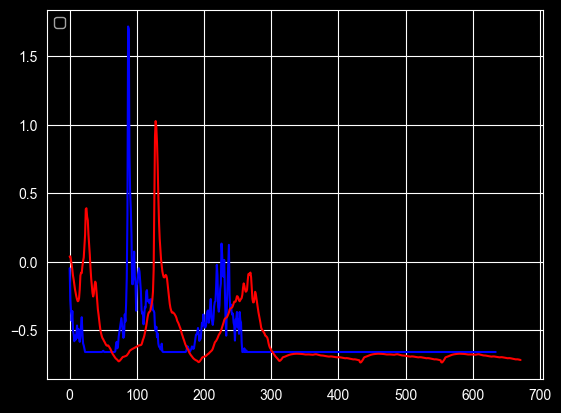

In [104]:
plt.plot(y_true, color='blue')
plt.plot(y_pred, color='red')
plt.legend(loc='upper left')
#plt.xlim(0, 300)
#plt.ylim(0, 800)
plt.show()